In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
import cusignal
import pandas as pd
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import transformation_funcs as tfs
torch.cuda.set_device(0) 

def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/snomed_codes.csv",sep=",")[["Dx","SNOMEDCTCode"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMEDCTCode"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_ID = "CPSC2018"
# DATASET_ID = "ChapmanShaoxing"
DATASET_NAME = "WFDB_%s_signitured"%DATASET_ID
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)

X = X.astype(float)
y = y


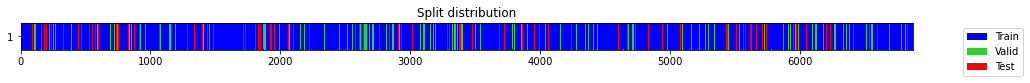

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [27]:

cv_splits = get_splits(y.to_numpy(), n_splits =1, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

# Test out transformations after dataloading here (slower)

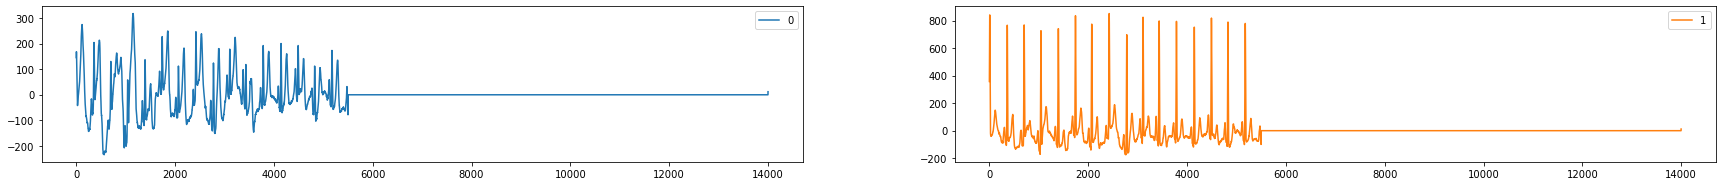

In [31]:
# %%time
sf = 0.5
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
             TSStandardize(by_sample=True),
                tfs.BandPass(500,3,100),
                tfs.Scale(scale_factor=sf,mode="nearest"),
                tfs.Normalize(),
              tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=cv_splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=[], num_workers=0,shuffle_train=False,)
dls_transformed   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0,shuffle_train=False,)
for batch in dls.train:
    b = batch
x = b[0][0]
b[1][0]
fig = pd.DataFrame(x.cpu()[0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

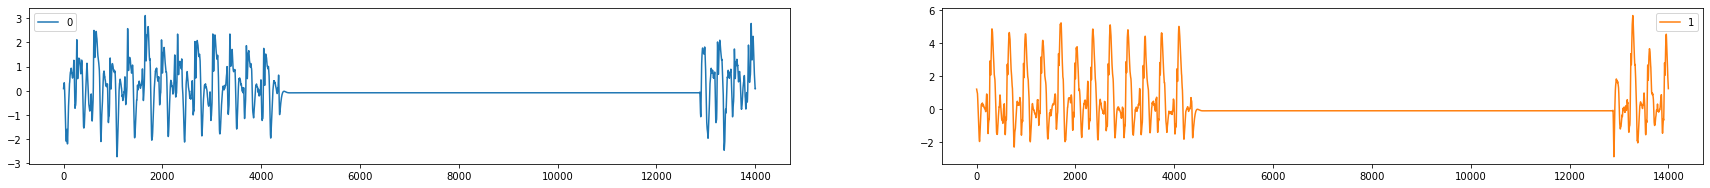

In [32]:
for batch in dls_transformed.train:
    b = batch
x = b[0][0]
b[1][0]
fig = pd.DataFrame(x.cpu()[0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

# direct transformations on individual arrays (faster)

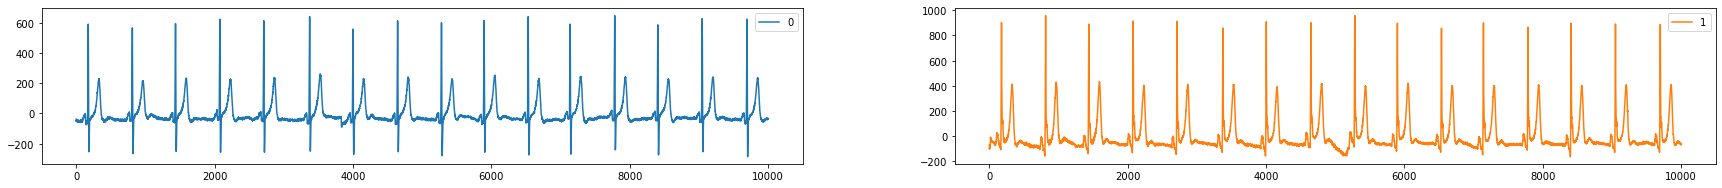

In [107]:
# raw
ecg_tensor = TSTensor(X[0:60,:,0:10000])
sf = 0.5
ecg_tensor = tfs.Normalize()(ecg_tensor)
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.BandPass(int(sf*500),low_cut=45, high_cut=0,leads=12,)(ecg_tensor)
ecg_tensor = tfs.RandomShift(0.5).encodes(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,5))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 20,loc="upper right")
plt.tight_layout()
plt.savefig("images/raw.pdf")

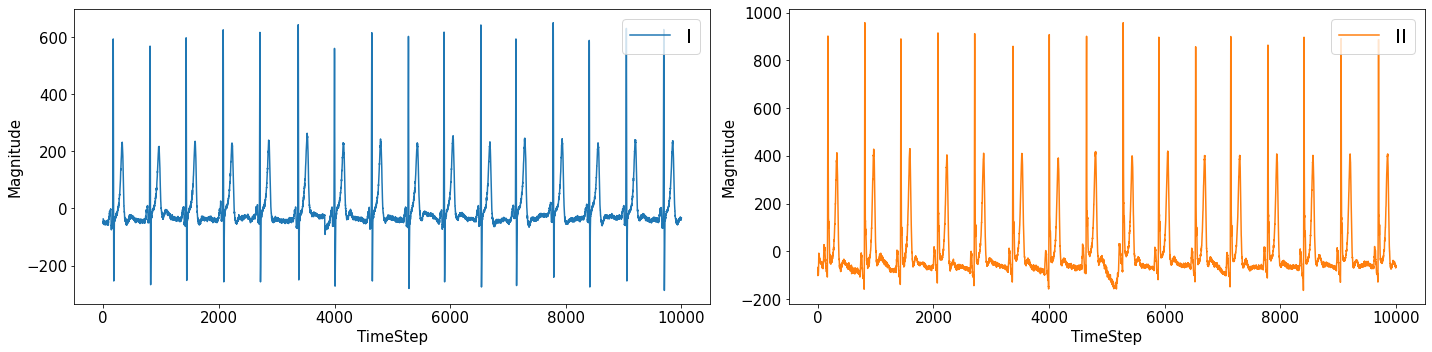

In [318]:
# raw
ecg_tensor = TSTensor(X[0:60,:,0:10000])
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,5))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 20,loc="upper right")
plt.tight_layout()
plt.savefig("images/raw.pdf")



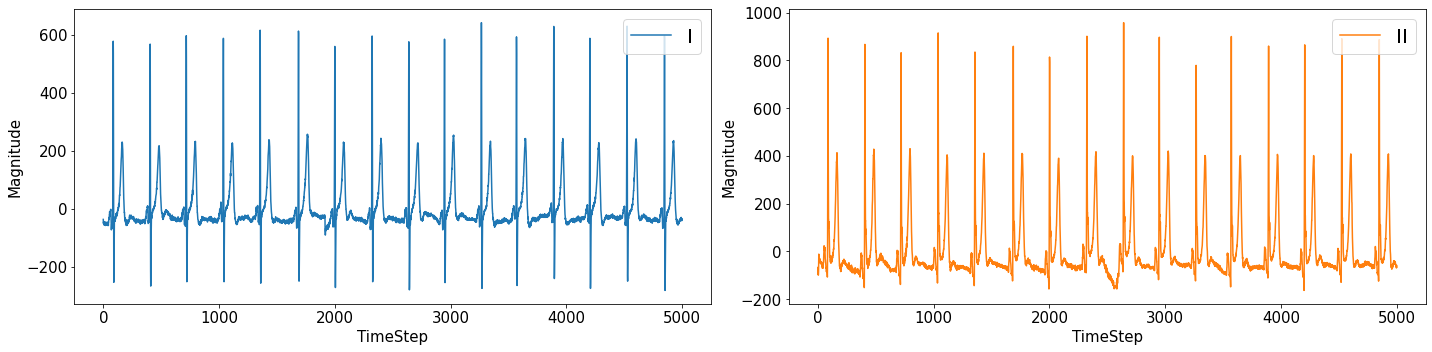

In [319]:
# sc
ecg_tensor = TSTensor(X[0:60,:,0:10000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,5))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 20,loc="upper right")
plt.tight_layout()
plt.savefig("images/sc.pdf")



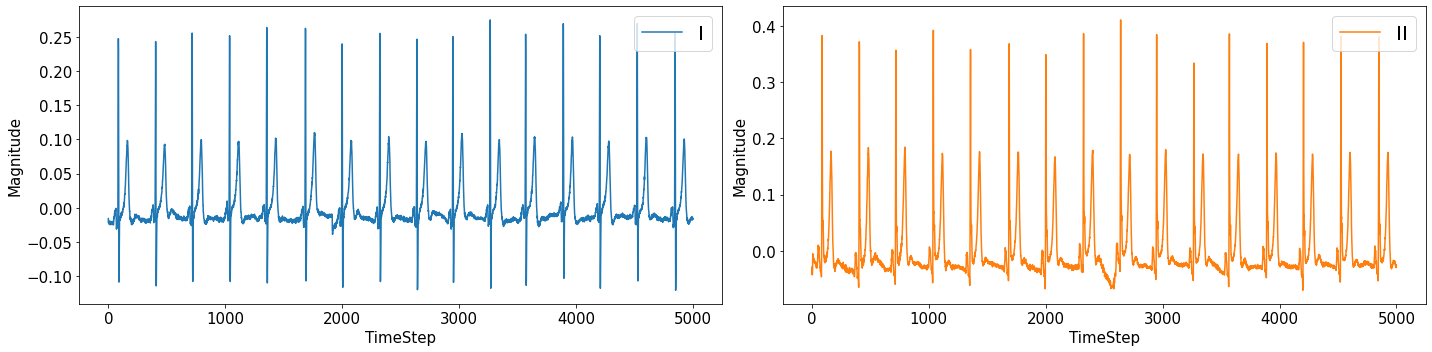

In [320]:
# sc-n
ecg_tensor = TSTensor(X[0:60,:,0:10000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.Normalize()(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,5))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 20,loc="upper right")
plt.tight_layout()
plt.savefig("images/sc-n.pdf")



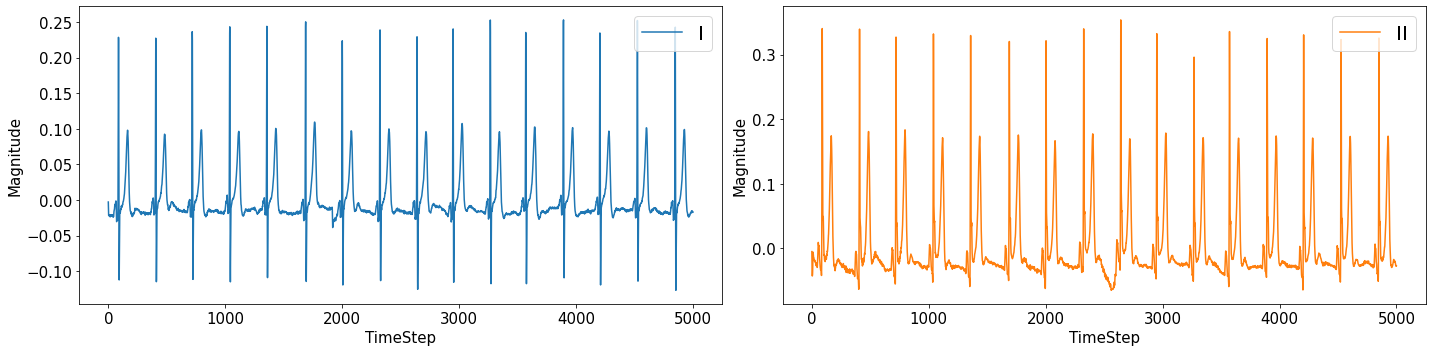

In [321]:
# sc-n-bp
ecg_tensor = TSTensor(X[0:60,:,0:10000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.Normalize()(ecg_tensor)
ecg_tensor = tfs.BandPass(int(sf*500),low_cut=45, high_cut=0,leads=12,)(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,5))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 20,loc="upper right")
plt.tight_layout()
plt.savefig("images/sc-n-bp.pdf")



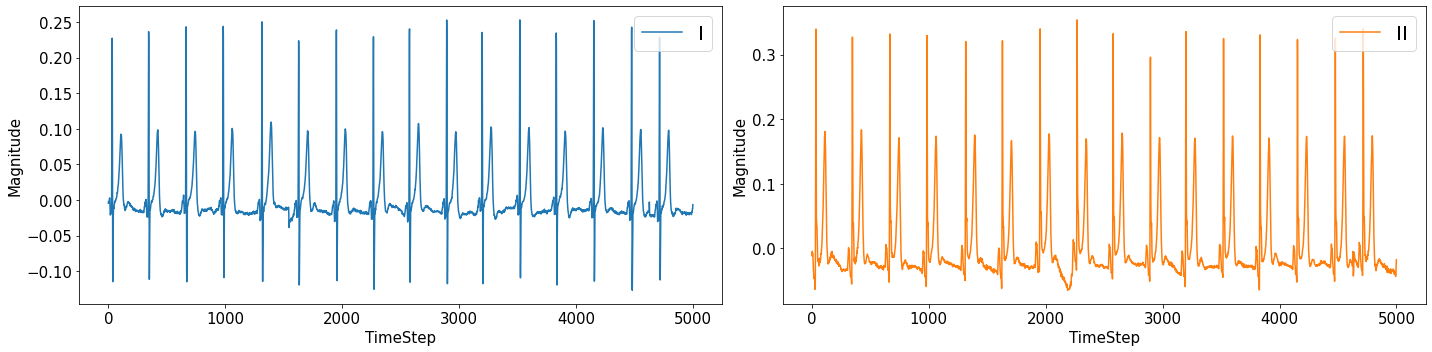

In [324]:
# sc-n-bp-sh
ecg_tensor = TSTensor(X[0:60,:,0:10000])
sf = 0.5
ecg_tensor = tfs.Scale(scale_factor=sf,)(ecg_tensor)
ecg_tensor = tfs.Normalize()(ecg_tensor)
ecg_tensor = tfs.BandPass(int(sf*500),low_cut=45, high_cut=0,leads=12,)(ecg_tensor)
ecg_tensor = tfs.RandomShift(0.5).encodes(ecg_tensor)
transformed_ecg = pd.DataFrame(ecg_tensor[45].cpu()[0:2]).T
transformed_ecg.columns = ["I","II"]
# modify plot and save
transformed_ecg.plot.line(subplots = True,layout=(1,2), figsize=(20,5))
for ax in plt.gcf().axes:
    ax.tick_params( which='both', labelsize=15)
    ax.set_ylabel("Magnitude", fontsize = 15)
    ax.set_xlabel("TimeStep", fontsize = 15)
    ax.legend(fontsize = 20,loc="upper right")
plt.tight_layout()
plt.savefig("images/sc-n-bp-sh.pdf")

